# Test Gumbel Function

In [67]:
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline 

In [72]:
# tau range between [0.1-1], the smaller the closer to softmax
self.tau = 0.3 
def gumbelSoftmax(x):        
    gumbelNoiseArray = -torch.log(-torch.log((torch.rand_like(x)+0.001) / 1.002))        
    softmaxOutput = (F.softmax(x,1)+0.001) / 1.002        
    noisySoftmaxOutput = (torch.log(softmaxOutput)+gumbelNoiseArray) / 0.3
#     noisySoftmaxOutput = (torch.log(softmaxOutput)+gumbelNoiseArray) / self.tau
    return F.softmax(noisySoftmaxOutput, 1)

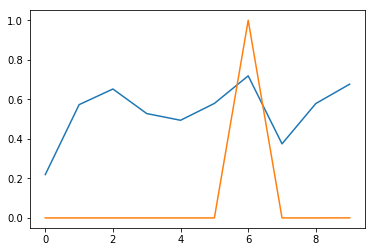

In [83]:
x = torch.rand(1, 10)
plt.plot(x.numpy()[0])
plt.plot(gumbelSoftmax(x).numpy()[0])

# Test Top-Down Attention Structure

In [42]:
# Load arguments
import os
import re
import utils
import torch
import random
import string
import pickle
import matplotlib
import numpy as np
import pandas as pd
import utils.options
import torch.nn as nn
import scipy.io as sio
import torch.nn.functional as F
from nltk.stem import PorterStemmer
from torch.autograd import Variable
from tensorboardX import SummaryWriter
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from utils.video_dataset import Dataset
from tensorboard_logger import log_value
from utils.detectionMAP import getDetectionMAP as dmAP
from utils.classificationMAP import getClassificationMAP as cmAP
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

torch.set_default_tensor_type('torch.cuda.FloatTensor')

import matplotlib.pyplot as plt
%matplotlib inline  

class Args():
    def __init__(self):
        self.lr = 0.0001
        self.dataset_name = 'Thumos14reduced'
        self.num_class = 20
        self.feature_size = 2048
        self.batch_size = 24
        self.max_seqlen = 750
        self.model_name = 'weakloc'
        self.pretrained_ckpt = None
        self.max_iter = 50000
        self.num_similar = 3
        self.checkpoint_path = './checkpoint/'
        self.annotation_path = './annotations/'
        self.I3D_path = './I3D_features/'


# Category to sentence
class_name = {0: ["baseball pitch", "throw a baseball", "baseball throw"],
             1: ["basketball dunk", "dunk a basketball", "slam dunk basketball"],
             2: ["billiards"],
             3: ["clean and jerk", "weight lifting movement"],
             4: ["cliff diving", "high diving", "diving"],
             5: ["cricket shot" ],
             6: ["cricket bowling", "cricket movement", "bowl cricket"],
             7: ["diving", "jumping into water", "falling into water"],
             8: ["frisbee catch", "catch frisbee"],
             9: ["golf swing", "golf stroke"],
            10: ["hammer throw", "throw a hammer"],
            11: ["high jump"],
            12: ["javelin throw", "throw a spear"],
            13: ["long jump", "jump contest"],
            14: ["pole vault", "a person uses a long flexible pole to jump over a bar"],
            15: ["shot put"],
            16: ["soccer penalty"],
            17: ["tennis swing"],
            18: ["throw discus", "discus"],
            19: ["volleyball spiking", "volleyball", ]}

args = Args()

# Load the dataset
dataset = Dataset(args)

# Word Embedding Loading from GLOVE
path_to_glove = './checkpoint/glove.840B.300d.pkl'

with open(path_to_glove, "rb") as input_file:
    glove_model = pickle.load(input_file)

In [46]:
# Randomly selecting out single label and convert it to text
def one_label_text(labels):
    tem_labels = torch.zeros_like(labels)
    target = [[idx for idx, item in enumerate(label.tolist()) if item == 1] for label in labels]
    for i, l in enumerate(target):
        idx = np.random.choice(l)
        tem_labels[i][idx] = 1
    text = label_to_text(tem_labels)
    return text, tem_labels


# Stacking all laebls to language format
def label_to_text(labels):
    text_list = []
    for label in labels:
        idxs = [idx for idx, val in enumerate(label) if val==1]
        text = ''
        for idx in idxs:
            text += ' ' + random.choice(class_name[idx])
        text_list.append(text)
    return text_list


# L1 normalization for weights regularization
def l1_norm(inputs):
    norm_value = torch.zeros(len(inputs)).cuda()
    for idx, vector in enumerate(inputs):
        norm_value[idx] = torch.norm(torch.abs(vector), p=1)
    return norm_value.sum()


# Sample single label from multi ground truth
def multi_to_single(labels):
    l = []
    for lab in labels:
        l.append(lab.tolist().index(1))
    return torch.from_numpy(np.asarray(l)).cuda()


# T-cam with specific label
def temporal_proposals(weights, features, clses):
    """
        Return the binary temporal proposals based on T-CAM.
        Input: 
            features:    (batch, # of segments, # of dim)
            cls:         (batch, class_label)
        Return:    [batch, # of untrimmed segments(binary)]
    """
    proposals = []
    # Iterate through batch
    for idx, video_feature in enumerate(features):
        # Chunk video feature to real length
            seq_len = (torch.abs(video_feature).max(dim=1)[0] > 0).sum().tolist()
            video_feature = video_feature[: seq_len, :]
            scores = np.zeros(seq_len)
            for seg_id, feature in enumerate(video_feature):
                for cls in clses[idx]:
                    score = (feature*weights[cls]).sum()
                    scores[seg_id] += score
            # Labeling segments with scores larger than threshold
            threshold = (np.max(scores) - (np.max(scores) - np.min(scores))*0.5)
            proposals.append([1 if s > threshold else 0 for idx, s in enumerate(scores)])
    return proposals


def temp2(attention_weights, labels):
    weights = torch.zeros(len(attention_weights), 20)
    idx_list = [i for i, val in enumerate(labels) if val == 1.0]
    for idx, val in enumerate(idx_list):
        weights[:, val] = attention_weights
    return weights


    
    
class Model(nn.Module):
    """Args:
        Video I3D features and raw natural text.
    """
    def __init__(self, input_dim, hidden_dim, batch_size, time_steps, output_dim=100, 
                 num_layers=2, path_to_glove = './checkpoint/glove.840B.300d.pkl'):
        super(Model, self).__init__()
        """
            Create Duo Strean Model.
        """
        self.textual_model = Language_encoder(lstm_input_size, hidden_dim, batch_size=batch_size, 
                                 time_steps=8, output_dim=output_dim, num_layers=num_layers, path_to_glove
                                              =path_to_glove)
        self.visual_model = Visual_model()
    
    def forward(self, visual_feature, text, t_proposals=None, test=False):
        """
            pos/neg_feature: (batch, 2048).       
                mean_pooled representations.
        """
        textual_feature = self.textual_model(text)
        attention_weights, visual_feature, pos_feature, neg_feature, test_features = \
            self.visual_model(visual_feature, text, t_proposals=t_proposals, test=test)

        return attention_weights, visual_feature, textual_feature, pos_feature, neg_feature, test_features
    
    
    

# Build up the language model and LSTM
class Language_encoder(nn.Module):
    """Args:
        Natural Language Text.
    """
    def __init__(self, input_dim, hidden_dim, batch_size, time_steps, output_dim=100, 
                 num_layers=2, path_to_glove = './checkpoint/glove.840B.300d.pkl'):
        super(Language_encoder, self).__init__()
        """
            Load GLOVE pre-trained model first.
        """
        with open(path_to_glove, "rb") as input_file:
            self.glove = pickle.load(input_file)
        self.wordnet_lemmatizer = WordNetLemmatizer() 

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.time_steps = time_steps
        
        # Define the LSTM/fc module
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def language_preprocess(self, input_str):
        # convert to lowercase
        input_str = input_str.lower()
        # remove numbers
        input_str = re.sub(r'\d+', '', input_str)
        # remove punctuation
        input_str = re.sub(r'[^\w\s]','',input_str)
        # remove whitespaces
        input_str = input_str.strip()
        # remove stop words
        stop_words = set(ENGLISH_STOP_WORDS)
        tokens = word_tokenize(input_str)
        words = [i for i in tokens if not i in stop_words]
        # stemming the words
        words = [self.wordnet_lemmatizer.lemmatize(word) for word in words]
        return words
    
    def zero_pad_feature(self, word_dict):
        # transform to tensor input, and zero padding the extra feature
        input_seq = torch.zeros(self.time_steps, len(word_dict), lstm_input_size).cuda()
        
        for i in range(len(word_dict)):
            for j in range(self.time_steps):
                if j < len(word_dict[i]):
                    # word2vec extracting
                    input_seq[j, i, :] = torch.from_numpy(glove_model[word_dict[i][j]]).cuda()
        return input_seq
    
    def forward(self, text):
        """
            Text will be pre-processed first, and zero-padded for LSTM input.
        """
        word_dict = []
        for lines in text:
            word_dict.append(self.language_preprocess(lines))
        input_seq = self.zero_pad_feature(word_dict)
        
        lstm_out, _ = self.lstm(input_seq)
        last_output = lstm_out[-1]
        output = self.linear(last_output)
        
        return output


    
class Visual_model(nn.Module):
    """Args:
    feature_dim: dimension of the feature from I3D model.
    """

    def __init__(self, feature_dim=2048):
        super(Visual_model, self).__init__()
        
        self.feature_dim = feature_dim
        self.fc0 = nn.Linear(feature_dim, 1024)
        self.fc1 = nn.Linear(1024, 256)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(256, 1)
        self.sigmoid = nn.Sigmoid()
        self.fc_lr = nn.Linear(2048, 100)
        self.language_encoder = Language_encoder(300, 300, batch_size=1, time_steps=8, output_dim=256, num_layers=2, 
                                            path_to_glove=path_to_glove)
        
        # Bilinear Module: input: (# seg * 2048d), (1 * 300d); output: (# seg * 256)
        self.bilinear_pooling = nn.Bilinear(256, 100, 256)

    def forward(self, features_list, text_list, t_proposals=None, test=False):
        """Build the attention module.

        Args:
        features_list: (batch_size, num_frame, feat_depth)
        t_proposals:    temporal proposals generated from T-CAM, for boostrapping LSTM training.
        language_vector: top-down signal, (batch_size, feat_dim)

        Returns:
        The attention weights, weigted features
        """
        # Test_features are returning tensors (batch, length, feat_dim)
        attention_weights = []
        weighted_features = []
        pos_features = []
        neg_features = []
        test_features = []
        text_features = self.language_encoder(text_list)
        
        # Iterate through batch since length of each video segment varies
        for idx, video_features in enumerate(features_list):
            # Trunk feature into real length
            seq_len = (torch.abs(video_features).max(dim=1)[0] > 0).sum().tolist()
            video_features = video_features[: seq_len, :]

            # Expand the size of language size
            language_feat = text_features[idx]
            language_feat = self.sigmoid(language_feat.expand(video_features.shape[0], language_feat.shape[-1]))

            # Iterate through video segments
#             bilinear = self.relu(self.bilinear_pooling(self.relu(self.fc1(self.relu(self.fc0(video_features)))), language_feat))
            bilinear = self.relu(self.fc1(self.relu(self.fc0(video_features)))*language_feat)
#             bilinear = self.relu(self.fc1(self.relu(self.fc0(video_features))))
            output = self.sigmoid(self.fc2(bilinear))

            # Temporal Pool
            weighted_pooling = (output*video_features).sum(0)/video_features.shape[0]
            
            # If testing, feed weighted video_features (no mean pool) to fc_lr
            if test:
                test_features.append(self.fc_lr((output*video_features)))
            
            # Save weights/features
            output = output.reshape(output.shape[0])
            attention_weights.append(output)
            weighted_features.append(weighted_pooling)

            # Pool pos/neg segments features from T-CAM proposals
            if t_proposals is not None:
                pos_list = [index for index, l in enumerate(t_proposals[idx]) if l == 1.]
                neg_list = [index for index, l in enumerate(t_proposals[idx]) if l == 0.]
                
                pos_feature = torch.stack([feat for index, feat in enumerate(video_features) 
                                           if index in pos_list]).sum(0)/len(pos_list)
                neg_feature = torch.stack([feat for index, feat in enumerate(video_features) 
                                           if index in neg_list]).sum(0)/len(neg_list)
                
                pos_features.append(pos_feature)
                neg_features.append(neg_feature)
                
        # Reshape to tensor
        weighted_features = torch.stack(weighted_features)

        # Feed temporal features to fc regression layer
        # output: aggregated visual representations
        output = self.fc_lr(weighted_features)
        
        if test:
            return attention_weights, output, None, None, test_features
        else:
            # training without t-cam bootstrapping
            if t_proposals is None:
                return attention_weights, output, None, None, None
            # training with t-cam bootstrapping
            else:
                pos_features = torch.stack(pos_features)
                neg_features = torch.stack(neg_features)
                pos_features = self.fc_lr(pos_features)
                neg_features = self.fc_lr(neg_features)
                return attention_weights, output, pos_features, neg_features, None

In [81]:
# Duo Model testing
lstm_input_size = 300
hidden_dim = 300
batch_size = 1
output_dim = 100
num_layers = 2

model = Model(lstm_input_size, hidden_dim, batch_size=batch_size, 
                                 time_steps=8, output_dim=output_dim, num_layers=num_layers)

# Load pre-trained classification network for bootstrapping
checkpoint = torch.load('./checkpoint/temporal_cls_epoch_15000_bceloss.pth')
pretrained_dict = checkpoint['state_dict']

fc_weight = pretrained_dict['fc3.weight']

# filter out unnecessary keys and load valid params
model_dict = model.visual_model.state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)  
model.visual_model.load_state_dict(model_dict)


model.cuda()
model.textual_model.cuda()
model.visual_model.cuda()
print('model created')

# Store the fc weights for t-cam prediction
# args.weights = model.visual_model.fc3.weight.detach().cpu()
args.weights = fc_weight.cpu()
args.margin_weight = 0.01
args.lr = 0.0001

# Loss defined here
marginrankingloss = nn.MarginRankingLoss(0.1)

def euclidean_distance(v1, v2, dim=None):
    if dim is not None: 
        return torch.mean((v1-v2)**2, dim)
    else:
        return torch.mean((v1-v2)**2)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)

writer = SummaryWriter()

model created


Epoch:000, Loss: 0.015829386189579964


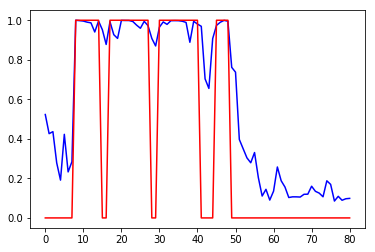

In [ ]:
for epoch in range(args.max_iter):
    # Randomly extract 10 video clips' I3D feature
    features, labels = dataset.load_data(n_similar=args.num_similar)

    # Features are alingned in 750 frames all the same, now trunk it into max length
    seq_len = np.sum(np.max(np.abs(features), axis=2) > 0, axis=1)
    features = features[:,:np.max(seq_len),:]

    # Convert to CUDA tensor
    features = torch.from_numpy(features).float().to('cuda')
    labels = torch.from_numpy(labels).float().to('cuda')

    # Generate texts from categories
    text_list, labels = one_label_text(labels)

    # Generate Pos/Neg temporal segment mask for contrastive loss
    clses = [[idx for idx, cls in enumerate(label) if cls == 1.] for label in labels]
    t_proposals = temporal_proposals(args.weights, features.detach().cpu(), clses)

    attention_weights, visual_feature, textual_feature, pos_feature, neg_feature, test_features\
        = model(features, text_list, t_proposals)

    # Squared Loss, Margin Ranking Loss
    pos_distance = euclidean_distance(pos_feature, textual_feature, 1)
    neg_distance = euclidean_distance(neg_feature, textual_feature, 1)
    target = torch.zeros(visual_feature.shape[0]).cuda()-1

    margin_loss = marginrankingloss(pos_distance, neg_distance, target)

    loss = euclidean_distance(visual_feature, textual_feature) + args.margin_weight*margin_loss 
#     + 0.000001*l1_norm(attention_weights)


    
    # Back Propogation
    optimizer.zero_grad() 
    loss.backward()  
    optimizer.step()
    
        
    # Save checkpoint
    if epoch % 5000 == 0 and epoch is not 0:
        # Reduce lr 
        args.lr /= 2
#         args.margin_weight /= 2
        optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)
        
        # Checkpoint structure
        model_state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        }
        torch.save(model_state, os.path.join(args.checkpoint_path, 'model_nlp_top-down_epoch_{:03}.pth'.format(epoch)))
    

    # Print out training loss
    loss_value = loss.detach().cpu().tolist()
    writer.add_scalar('runs/', loss_value, epoch)


    if epoch % 100 == 0:
        print('Epoch:{:03}, Loss: {:02}'.format(epoch, loss_value))
        # Display attention weights and loss value
        plt.plot(attention_weights[0].tolist(), c='b')
        plt.plot(t_proposals[0], c='r')
        plt.show()
        
# export scalar data to JSON for external processing
writer.export_scalars_to_json("./all_scalars.json")
writer.close()

## Test Temporal Localization of Language Weakly Training

In [49]:
# Duo Model testing

# Load pre trained model
lstm_input_size = 300
hidden_dim = 300
batch_size = 1
output_dim = 100
num_layers = 2

model = Model(lstm_input_size, hidden_dim, batch_size=batch_size, 
                                 time_steps=8, output_dim=output_dim, num_layers=num_layers)
model.eval()
model.cuda()
checkpoint = torch.load('./checkpoint/model_nlp_top-down_epoch_5000.pth')
model.load_state_dict(checkpoint['state_dict'])
epoch = checkpoint['epoch']

print('model loaded')

model loaded


In [50]:
# Similarities among visual-textual features
def visual_textual_sim(sing_video_feat, cls_num=20):
    """
        return (segments, class_num)
    """
    # Compute Similarities Across Video-Textual features
    weights = np.zeros((sing_video_feat.shape[0], cls_num))
    for idx1, seg_feat in enumerate(sing_video_feat):
        for idx2 in range(cls_num):
            # Randomly picking out one textual label
            rand = np.random.randint(len(language_feat_dict[idx2]))
            textual_feat = language_feat_dict[idx2][rand]
            weights[idx1, idx2] = euclidean_distance(textual_feat, seg_feat)
    return weights


def test(itr, dataset, args, model, logger, device):
    
    done = False
    instance_logits_stack = []
    element_logits_stack = []
    labels_stack = []
    while not done:
        if dataset.currenttestidx % 100 ==0:
            print('Testing test data point %d of %d' %(dataset.currenttestidx, len(dataset.testidx)))

        features, labels, done = dataset.load_data(is_training=False)
        features = torch.from_numpy(features).float().to(device)
        
        # Generate texts from categories
        text_list = label_to_text([labels])
        
        attention_weights, visual_feature, textual_feature, pos_feature, neg_feature, test_features \
            = model([features], text_list, None, test=True)

        # Computing T-cam weights
#         weights = visual_textual_sim(test_features[0])
        weights = temp2(attention_weights[0], labels)
        weights = weights.detach().cpu().numpy() 
        element_logits_stack.append(weights)
        labels_stack.append(labels)

    labels_stack = np.array(labels_stack)

    dmap, iou = dmAP(element_logits_stack, dataset.path_to_annotations)
    
    if args.dataset_name == 'Thumos14':
        test_set = sio.loadmat('test_set_meta.mat')['test_videos'][0]
        for i in range(np.shape(labels_stack)[0]):
            if test_set[i]['background_video'] == 'YES':
                labels_stack[i, :] = np.zeros_like(labels_stack[i,:])

    print('Detection map @ %f = %f' %(iou[0], dmap[0]))
    print('Detection map @ %f = %f' %(iou[1], dmap[1]))
    print('Detection map @ %f = %f' %(iou[2], dmap[2]))
    print('Detection map @ %f = %f' %(iou[3], dmap[3]))
    print('Detection map @ %f = %f' %(iou[4], dmap[4]))

    return element_logits_stack, labels_stack

In [51]:
from tensorboard_logger import Logger
logger = Logger('./logs/' + 'Testing')
device = torch.device("cuda")

element_logits_stack, labels_stack = test(0, dataset, args, model, logger, device)

Testing test data point 0 of 212
Testing test data point 100 of 212
Testing test data point 200 of 212
Testing for IoU 0.100000
Testing for IoU 0.200000
Testing for IoU 0.300000
Testing for IoU 0.400000
Testing for IoU 0.500000
Detection map @ 0.100000 = 47.910627
Detection map @ 0.200000 = 39.081805
Detection map @ 0.300000 = 28.661714
Detection map @ 0.400000 = 20.136377
Detection map @ 0.500000 = 13.260246
